In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.datasets import CocoDetection
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
class CocoTransform:
    def __call__(self, image, target):
        image = F.to_tensor(image)  # Convert PIL image to tensor
        return image, target

In [3]:
# Dataset class
def get_coco_dataset(img_dir, ann_file):
    return CocoDetection(
        root=img_dir,
        annFile=ann_file,
        transforms=CocoTransform()
    )

# Load datasets
train_dataset = get_coco_dataset(
    img_dir="C://Users//adhik//OneDrive//Desktop//Traffic Management System//traffic faster RCNN//train",
    ann_file="C://Users//adhik//OneDrive\Desktop//Traffic Management System//traffic faster RCNN//train//_annotations.coco.json"
)


val_dataset = get_coco_dataset(
    img_dir="C://Users//adhik//OneDrive\Desktop//Traffic Management System//traffic faster RCNN//valid",
    ann_file="C://Users//adhik//OneDrive//Desktop//Traffic Management System//traffic faster RCNN//valid//_annotations.coco.json"
)



# DataLoader
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

loading annotations into memory...
Done (t=0.23s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [4]:
def get_model(num_classes):
    # Load pre-trained Faster R-CNN
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [6]:
num_classes = 3
model = get_model(num_classes)

In [7]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Define optimizer and learning rate scheduler
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [8]:
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()
    for images, targets in data_loader:
        # Move images to the device
        images = [img.to(device) for img in images]

        # Validate and process targets
        processed_targets = []
        valid_images = []
        for i, target in enumerate(targets):
            boxes = []
            labels = []
            for obj in target:
                # Extract bbox
                bbox = obj["bbox"]  # Format: [x, y, width, height]
                x, y, w, h = bbox

                # Ensure the width and height are positive
                if w > 0 and h > 0:
                    boxes.append([x, y, x + w, y + h])  # Convert to [x_min, y_min, x_max, y_max]
                    labels.append(obj["category_id"])

            # Only process if there are valid boxes
            if boxes:
                processed_target = {
                    "boxes": torch.tensor(boxes, dtype=torch.float32).to(device),
                    "labels": torch.tensor(labels, dtype=torch.int64).to(device),
                }
                processed_targets.append(processed_target)
                valid_images.append(images[i])  # Add only valid images

        # Skip iteration if no valid targets
        if not processed_targets:
            continue

        # Ensure images and targets are aligned
        images = valid_images

        # Forward pass
        loss_dict = model(images, processed_targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backpropagation
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    print(f"Epoch [{epoch}] Loss: {losses.item():.4f}")

In [9]:
num_epochs = 5
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch)
    lr_scheduler.step()
    
    # Save the model's state dictionary after every epoch
    model_path = f"fasterrcnn_resnet50_epoch_{epoch + 1}.pth"
    torch.save(model.state_dict(), model_path)
    print(f"Model saved: {model_path}")

Epoch [0] Loss: 1.0426
Model saved: fasterrcnn_resnet50_epoch_1.pth


KeyboardInterrupt: 

C:\Users\adhik\AppData\Local\Temp\ipykernel_8496\3693160653.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("fasterrcnn_resnet50_epoch_1.pth")


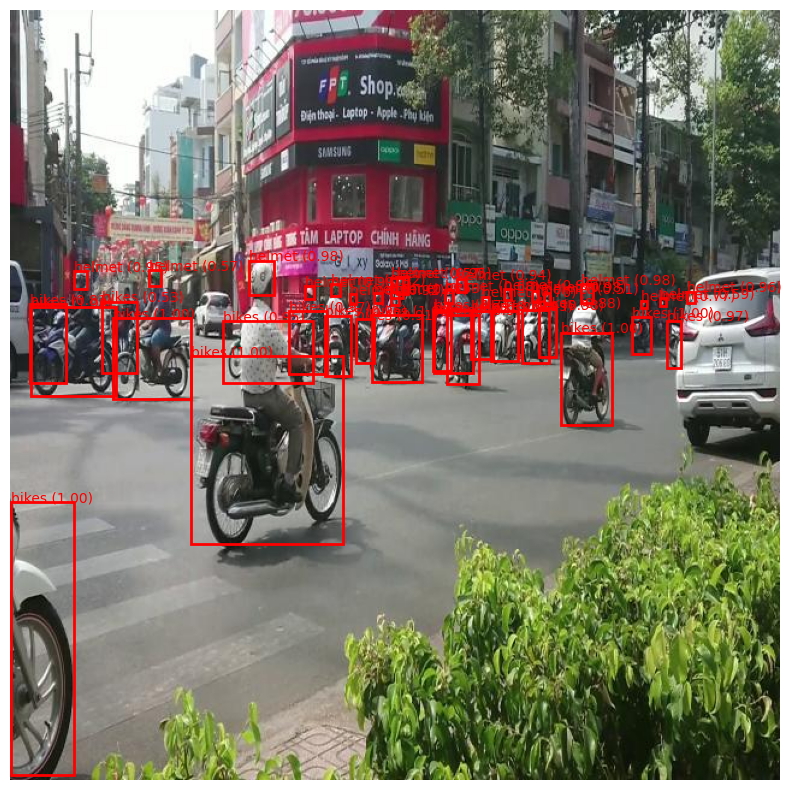

In [13]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.datasets import CocoDetection
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
from PIL import Image

# Load Faster R-CNN with ResNet-50 backbone
def get_model(num_classes):
    # Load pre-trained Faster R-CNN
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model


# Initialize the model
num_classes = 3  # Background + chair + person + table

# Move model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


# Load the trained model
model = get_model(num_classes)
checkpoint = torch.load("fasterrcnn_resnet50_epoch_1.pth")
model_dict = model.state_dict()

# Filter out unnecessary keys
pretrained_dict = {k: v for k, v in checkpoint.items() if k in model_dict and model_dict[k].shape == v.shape}

# Overwrite entries in the existing state dict
model_dict.update(pretrained_dict)

# Load the new state dict
model.load_state_dict(model_dict)
model.to(device)
model.eval()  # Set the model to evaluation mode


def prepare_image(image_path):
    image = Image.open(image_path).convert("RGB")  # Open image
    image_tensor = F.to_tensor(image).unsqueeze(0)  # Convert image to tensor and add batch dimension
    return image_tensor.to(device)



# Load the unseen image
image_path = "C://Users//adhik//OneDrive//Desktop//Traffic Management System//traffic faster RCNN//test//frame_0005_png.rf.07217048813e7b812d5f31bac0e6c62d.jpg"
image_tensor = prepare_image(image_path)

with torch.no_grad():  # Disable gradient computation for inference
    prediction = model(image_tensor)

# `prediction` contains:
# - boxes: predicted bounding boxes
# - labels: predicted class labels
# - scores: predicted scores for each box (confidence level)
COCO_CLASSES = {0: "Background", 1: "bikes", 2: "helmet"}

def get_class_name(class_id):
    return COCO_CLASSES.get(class_id, "Unknown")
    
# Draw bounding boxes with the correct class names and increase image size
def draw_boxes(image, prediction, fig_size=(10, 10)):
    boxes = prediction[0]['boxes'].cpu().numpy()  # Get predicted bounding boxes
    labels = prediction[0]['labels'].cpu().numpy()  # Get predicted labels
    scores = prediction[0]['scores'].cpu().numpy()  # Get predicted scores
    
    # Set a threshold for showing boxes (e.g., score > 0.5)
    threshold = 0.5
    
    # Set up the figure size to control the image size
    plt.figure(figsize=fig_size)  # Adjust the figure size here

    for box, label, score in zip(boxes, labels, scores):
        if score > threshold:
            x_min, y_min, x_max, y_max = box
            class_name = get_class_name(label)  # Get the class name
            plt.imshow(image)  # Display the image
            plt.gca().add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, 
                                              linewidth=2, edgecolor='r', facecolor='none'))
            plt.text(x_min, y_min, f"{class_name} ({score:.2f})", color='r')
    
    plt.axis('off')  # Turn off axis
    plt.show()

# Display the image with bounding boxes and correct labels
draw_boxes(Image.open(image_path), prediction, fig_size=(12, 10))  # Example of increased size

In [18]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import functional as F
import cv2
from PIL import Image, ImageDraw, ImageFont
import numpy as np

# Load Faster R-CNN with ResNet-50 backbone
def get_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

# Initialize the model
num_classes = 3  # Background + Bikes + Helmet
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = get_model(num_classes)

# Load the trained model
checkpoint = torch.load("fasterrcnn_resnet50_epoch_1.pth", map_location=device)
model.load_state_dict(checkpoint)
model.to(device)
model.eval()

# Class mapping
COCO_CLASSES = {0: "Background", 1: "Bikes", 2: "Helmet"}

# Helper to get class names
def get_class_name(class_id):
    return COCO_CLASSES.get(class_id, "Unknown")

# Process video
video_path = "C://Users//adhik//OneDrive//Desktop//Traffic Management System//traffic faster RCNN//853908-hd_1920_1080_25fps.mp4"
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

# Output video writer (optional, to save results)
output_path = "output_video.mp4"
fps = int(cap.get(cv2.CAP_PROP_FPS))
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

# Add a frame skipping variable
frame_skip = 2  # Process every 2nd frame

# Adjust the resolution for faster processing
resize_width, resize_height = 640, 640

frame_count = 0  # Counter to skip frames

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Skip frames for better performance
    if frame_count % frame_skip != 0:
        frame_count += 1
        continue

    # Resize the frame for faster processing
    resized_frame = cv2.resize(frame, (resize_width, resize_height))

    # Convert frame to PIL Image for processing
    image = Image.fromarray(cv2.cvtColor(resized_frame, cv2.COLOR_BGR2RGB))

    # Prepare the image for the model
    image_tensor = F.to_tensor(image).unsqueeze(0).to(device)

    with torch.no_grad():
        prediction = model(image_tensor)

    # Draw bounding boxes and labels
    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()

    boxes = prediction[0]['boxes'].cpu().numpy()
    labels = prediction[0]['labels'].cpu().numpy()
    scores = prediction[0]['scores'].cpu().numpy()

    for box, label, score in zip(boxes, labels, scores):
        if score > 0.5:  # Confidence threshold
            x_min, y_min, x_max, y_max = box
            class_name = get_class_name(label)
            draw.rectangle([x_min, y_min, x_max, y_max], outline="red", width=3)
            draw.text((x_min, y_min - 10), f"{class_name} ({score:.2f})", fill="red", font=font)

    # Convert back to OpenCV format
    output_frame = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

    # Show the frame
    cv2.imshow("Faster R-CNN Detection", output_frame)

    # Write the frame to the output video
    out.write(output_frame)

    frame_count += 1

    # Break on 'q' key
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release resources
cap.release()
out.release()
cv2.destroyAllWindows()


C:\Users\adhik\AppData\Local\Temp\ipykernel_8496\3949740612.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("fasterrcnn_resnet50_epoch_1.pth", m